In [1]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [2]:
# Verificar se a GPU está disponível
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is not available


In [3]:
# Diretório onde estão armazenadas as imagens
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'

In [4]:
# Função para carregar e redimensionar as imagens
def load_image(image_path, target_size=(112, 112)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  
        return np.array(image) / 255.0  
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [5]:
# Carregar IDs do grupo de treinamento de um arquivo de texto
train_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\vague_train.txt'
with open(train_ids_file, 'r') as file:
    train_ids = [str(id) for id in json.loads(file.read())]

In [6]:
# Carregar IDs do grupo de validação de um arquivo de texto
val_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\vague_val.txt'
with open(val_ids_file, 'r') as file:
    val_ids = [str(id) for id in json.loads(file.read())]

In [7]:
%%capture
# Listas para armazenar caminhos de imagem e rótulos correspondentes
train_data = []
val_data = []

# Iterar sobre todos os arquivos no diretório
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Erro ao carregar JSON {json_path}: {e}")
                continue
        
        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"ID da amostra ausente no JSON: {json_path}")
            continue

        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Arquivo de imagem não encontrado: {image_path}")
            continue
        
        classes = json_data.get('classes', [])
        if not classes:
            print(f"Chave 'classes' ausente ou vazia no JSON: {json_path}")
            continue
        
        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [8]:
# Verificar o número de imagens carregadas
print(f"Número de imagens de treinamento carregadas: {len(train_data)}")
print(f"Número de imagens de validação carregadas: {len(val_data)}")

Número de imagens de treinamento carregadas: 642
Número de imagens de validação carregadas: 214


In [9]:
# Separar as imagens e os rótulos (labels)
train_images = [data[0] for data in train_data]
train_labels = [data[1] for data in train_data]

In [10]:
val_images = [data[0] for data in val_data]
val_labels = [data[1] for data in val_data]

In [11]:
# Carregar as imagens
train_images = [load_image(image_path, target_size=(112, 112)) for image_path in train_images]
val_images = [load_image(image_path, target_size=(112, 112)) for image_path in val_images]

In [12]:
# Verificar se alguma imagem falhou ao carregar
train_images = [img for img in train_images if img is not None]
val_images = [img for img in val_images if img is not None]

In [13]:
# Converter os rótulos em formato adequado (numérico)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

In [31]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Use sparse_output no lugar de sparse
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Ajuste o codificador nos rótulos de treino e transforme-os em one-hot encoding
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))

# Transforme os rótulos de validação
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

In [32]:
# Carregar o modelo base ResNet50 com pesos pré-treinados da ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

In [33]:
# Congelar as camadas da ResNet50 para treinar apenas as camadas personalizadas
base_model.trainable = False

In [34]:
# Adicionar novas camadas no topo do modelo base
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [35]:
# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

In [36]:
# Fine-tuning 
# Descongelar as últimas camadas da ResNet50 para fazer fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [37]:
# Recompilar o modelo 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [38]:
# Continuar o treinamento com fine-tuning
history_finetune = model.fit(
    np.array(train_images), 
    train_labels_one_hot, 
    epochs=20, 
    batch_size=32, 
    validation_data=(np.array(val_images), val_labels_one_hot)
)

Epoch 1/20
21/21 [==============================] - 31s 1s/step - loss: 0.9743 - accuracy: 0.5841 - val_loss: 1.0630 - val_accuracy: 0.4720
Epoch 2/20
21/21 [==============================] - 27s 1s/step - loss: 0.7661 - accuracy: 0.7056 - val_loss: 1.0136 - val_accuracy: 0.4720
Epoch 3/20
21/21 [==============================] - 25s 1s/step - loss: 0.7305 - accuracy: 0.7259 - val_loss: 0.9672 - val_accuracy: 0.4720
Epoch 4/20
21/21 [==============================] - 25s 1s/step - loss: 0.6794 - accuracy: 0.7477 - val_loss: 0.8990 - val_accuracy: 0.4766
Epoch 5/20
21/21 [==============================] - 25s 1s/step - loss: 0.7681 - accuracy: 0.7025 - val_loss: 0.8890 - val_accuracy: 0.4860
Epoch 6/20
21/21 [==============================] - 25s 1s/step - loss: 0.6685 - accuracy: 0.7414 - val_loss: 0.8850 - val_accuracy: 0.4907
Epoch 7/20
21/21 [==============================] - 26s 1s/step - loss: 0.7072 - accuracy: 0.7352 - val_loss: 0.8584 - val_accuracy: 0.5327
Epoch 8/20
21/21 [==

In [39]:
model.save('trained_model.resnet_vague_resolution')

INFO:tensorflow:Assets written to: trained_model.resnet_vague_resolution\assets


INFO:tensorflow:Assets written to: trained_model.resnet_vague_resolution\assets


In [40]:
# Avaliar no conjunto de validação
val_loss, val_accuracy = model.evaluate(np.array(val_images), val_labels_one_hot)
print(f"Loss no conjunto de validação: {val_loss}")
print(f"Accuracy no conjunto de validação: {val_accuracy}")

7/7 [==============================] - 5s 729ms/step - loss: 0.5904 - accuracy: 0.8131
Loss no conjunto de validação: 0.5904206037521362
Accuracy no conjunto de validação: 0.8130841255187988


In [41]:
target_names = ['Classe_0', 'Classe_1', 'Classe_2']

In [42]:
# Verifique as classes nos dados
print(f"Classes reais: {label_encoder.classes_}")

# Ajuste target_names conforme necessário
target_names = label_encoder.classes_

Classes reais: ['E.coli' 'P.aeruginosa' 'S.aureus']


In [43]:
from sklearn.metrics import confusion_matrix, classification_report

# Obter previsões do modelo
val_predictions = model.predict(np.array(val_images))

# Converter previsões one-hot encoded para rótulos
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)

# Matriz de confusão
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)
print("Matriz de Confusão:")
print(conf_matrix)

# Verifique as classes nos dados
print(f"Classes reais: {label_encoder.classes_}")

# Ajuste target_names conforme necessário
target_names = label_encoder.classes_

# Relatório de classificação
class_report = classification_report(val_labels_labels, val_predictions_labels, target_names=target_names)
print("Relatório de Classificação:")
print(class_report)

7/7 [==============================] - 7s 722ms/step
Matriz de Confusão:
[[89 12  0]
 [ 8 85  0]
 [ 5 15  0]]
Classes reais: ['E.coli' 'P.aeruginosa' 'S.aureus']
Relatório de Classificação:
              precision    recall  f1-score   support

      E.coli       0.87      0.88      0.88       101
P.aeruginosa       0.76      0.91      0.83        93
    S.aureus       0.00      0.00      0.00        20

    accuracy                           0.81       214
   macro avg       0.54      0.60      0.57       214
weighted avg       0.74      0.81      0.77       214



C:\Users\bruna\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bruna\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bruna\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
# Salvar a matriz de confusão e o relatório de classificação
np.save('confusion_matrix.npy', conf_matrix)

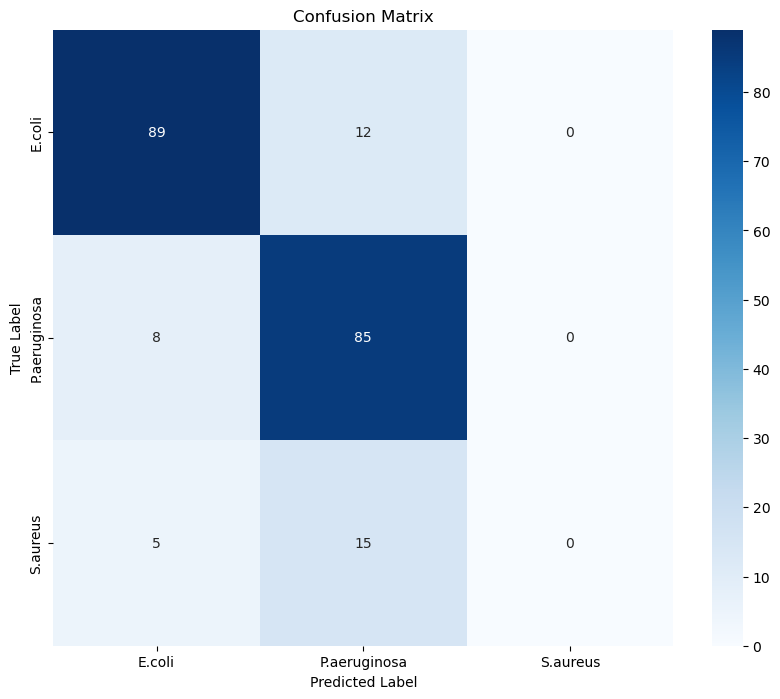

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()